In [1]:
%load_ext autoreload

import pickle
import sys
sys.path.append('../../..')
import numpy as np
from scipy.interpolate import interp1d
import darkhistory.physics as phys
import main

import matplotlib
matplotlib.rc_file('../../../matplotlibrc')
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as colors
%matplotlib inline

output_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/output/'
fig_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/figs/'

In this upgrade of DarkHistory we change our treatment of low energy electrons.  Rather than separating out sub-3keV electrons and applying MEDEA's interpolation files to determine the fractions of energy they deposit into each channel, we solve for their deposited energy directly.  Plugging this new treatment into main.evolve() generates a new set of $f_c(z)$.  We compare our new $f_c(z)$ to Fig. 18 of [1904.09296](https://arxiv.org/pdf/1904.09296.pdf).

In [2]:
def log10eng_to_mDM(log10eng, pri, DM_process):
    # Converts from log10eng to mDM
    if pri=='elec':
        if DM_process=='decay':
            mDM_list = 2*(10**log10eng + phys.me)
        else:
            mDM_list = 10**log10eng + phys.me
    elif pri=='phot':
        if DM_process=='decay':
            mDM_list = 2*10**log10eng
        else:
            mDM_list = 10**log10eng 
    return mDM_list

# Energy of injected particle
log10eng0 = 3.6989700794219966
log10eng = np.array([log10eng0 + 0.23252559*i for i in np.arange(40)])
log10eng[-1] = 12.601505994846297
eng = 10**log10eng

In [3]:
pri = 'elec'
DM_process = 'decay'

regenerate_data = False
        
if not regenerate_data:
    fs_data = pickle.load(open(
        output_dir+'fs_OLD_vs_NEW_xcheck.dat', 'rb'))
else:
    fs_data = {}
    for pri in ['elec', 'phot']:
        for DM_process in ['decay', 'swave']:
            key = pri+'_'+DM_process
            fs_data[key] = []
            mDM_list = log10eng_to_mDM(log10eng, pri, DM_process)
            for mDM in mDM_list:
                res = main.evolve(
                    DM_process=DM_process, mDM=mDM,
                    lifetime=1e40, sigmav=1e-40, primary=pri+'_delta',
                    start_rs=3e3, high_rs=1.555e3, end_rs=4,
                    cross_check=False, elec_method='new', backreaction=False,
                    reion_switch=False, reion_method='Puchwein', heat_switch=False,
                    coarsen_factor=16, rtol=1e-6,
                    distort=False, fexc_switch=False, reprocess_distortion=False,
                    nmax=10, iterations=1
                )
                fs_data[key].append(res['f'])
                pickle.dump(fs_data, open(output_dir+'fs_OLD_vs_NEW_xcheck.dat', 'wb'))

In [6]:
def get_fdiff(pri, DM_process, channel, ax, row, col):    
    ind = {'H ion' : 0, 'He ion' : 1, 'Lya' : 2, 'heat' : 3, 'cont' : 4}[channel]
    ch_std = ['H ion', 'He ion', 'exc', 'heat', 'cont']
    ch_run = ['H ion', 'He ion', 'Lya', 'heat', 'cont']
    rs_tmp = np.exp(np.arange(np.log(3e3), np.log(4), -.001*16))
    mDM_list = log10eng_to_mDM(log10eng, pri, DM_process)
    
    f_NEW = np.ones((eng.size, rs_tmp.size-2))*1e-6
    f_OLD = np.ones((eng.size, rs_tmp.size-2))*1e-6
    
    key = pri+'_'+DM_process
    
    for m_ind in np.arange(eng.size-1):
        f_OLD[m_ind] = phys.f_std(mDM_list[m_ind], rs_tmp[2:], 
                              pri, DM_process, channel=ch_std[ind])
        f_NEW[m_ind] = fs_data[key][m_ind][ch_run[ind]][2:]
    
    if ind < 2:
        label = {'H ion' : 'H_{ion}', 'He ion' : 'He_{ion}'}[channel]     
    else:
        label = channel
        
    title = r'\bf{$f_{'+label+'}$}'

    ax.loglog()
    
    levels=[0,.01,.05,.1,.2,.5,1.]#,.2,.3,.4,.5,1]
    
    diffs = np.zeros_like(f_NEW)
    diffs = np.abs(f_NEW - f_OLD)/f_NEW
    
    cs = ax.contourf(eng, rs_tmp[2:], np.transpose(diffs), levels = levels,
                     cmap=matplotlib.cm.RdBu_r, vmin=0, vmax=1.2)
    locmaj = matplotlib.ticker.LogLocator(base=100,numticks=12) 
    ax.xaxis.set_major_locator(locmaj)
    
    if row==0:
        ax.set_title(title)
    if col==0:
        ax.set_ylabel(r'Redshift ($1+z$)')
        if DM_process=='decay':
            init = r'$\chi$'
        else:
            init = r'$\chi\chi$'
        if pri=='elec':
            prod = r'$e^+ e^-$'
        else:
            prod = r'$\gamma \gamma$'
        ax.text(0.1, 0.1, init+r'$\rightarrow$'+prod, color='white', fontsize=20, transform = ax.transAxes)
    if row==3:
        ax.set_xlabel(r'Kinetic Energy [eV]')
        if col==0:
            cbar = plt.colorbar(cs, ticks=levels, fraction=0.046)
            cbar.ax.set_title(r'$\frac{|\Delta f_c|}{f_c}$', fontsize=16)

<Figure size 432x288 with 0 Axes>

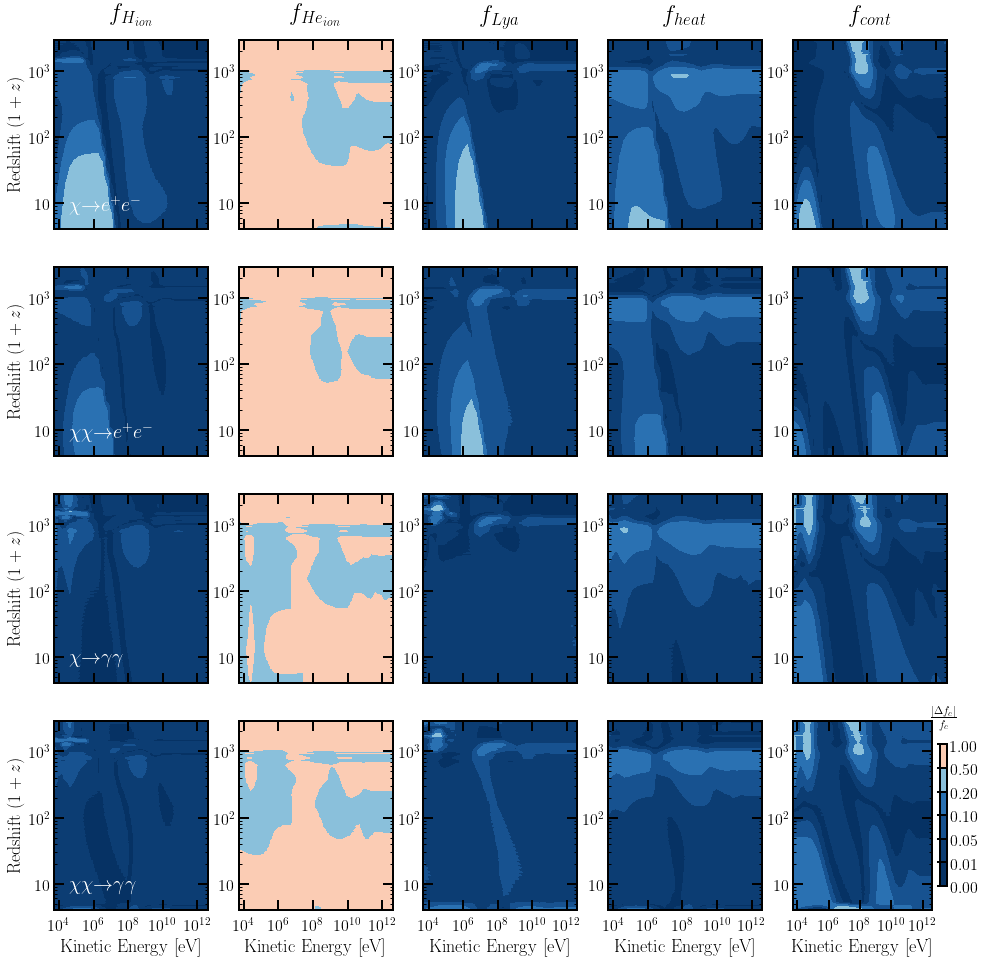

In [7]:
plt.figure()
f, axarr = plt.subplots(4,5, figsize = (16, 16), sharex=True)

row = 0
for pri in ['elec', 'phot']:
    for DM_process in ['decay', 'swave']:
        for col, chan in enumerate(['H ion', 'He ion', 'Lya', 'heat', 'cont']):
            get_fdiff(pri, DM_process, chan, axarr[row][col], row, col)
        row += 1
    
# f.tight_layout()
plt.savefig(fig_dir+'f_heatmap_crosscheck.pdf')